Our main goal is to be able to represent loaded music. We will use FFT for that.
What are the needs?
We're creating a video, let's say, 5 mins long, of 60fps. That means, we have 18.000 video frames in total.
If the incoming audio is of 44.100 sample rate, for each video frame we have 735 samples, so that would be our window for FFT analysis.

But, there's another thing to consider. The resulting texture.
Should it be updated each frame and contain only that window? Time consuming, we could fall off off being real time.
Or maybe we should prepare one texture of the whole song, where on Y axis it'd have FFT for a single frame, and frames would be put on X axis? Tat would be best, BUT - in case of our sampe 5mins long video it'd mean 18K length, that's not an option to load up as a texture into OpenGL...

In [12]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure


Ok, let's load some music

In [13]:
filename = 'test_sound_01.mp3'
audio, sample_rate = librosa.load(filename, sr=22500)
if audio.ndim > 1:
    audio = np.mean(audio, axis=1)
num_samples = audio.shape[0]
length = num_samples / sample_rate
max_sample_value = np.max(audio)

print(f'Audio sample rate: {sample_rate}, number of samples: {num_samples}. Length: {length}, max sample value is: {max_sample_value}')

Audio sample rate: 22500, number of samples: 1288980. Length: 57.288, max sample value is: 0.889253556728363


Let's draw simple waveform and frequency spectrum analysis:

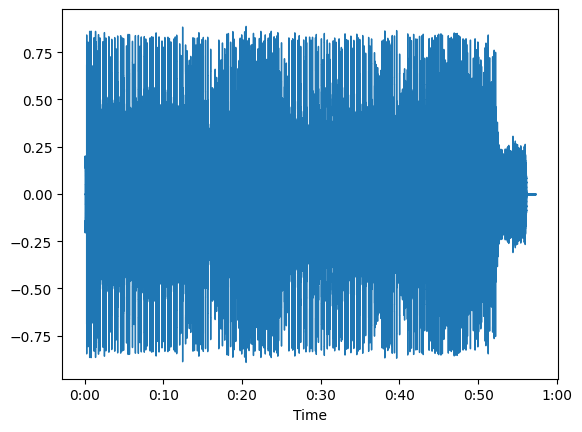

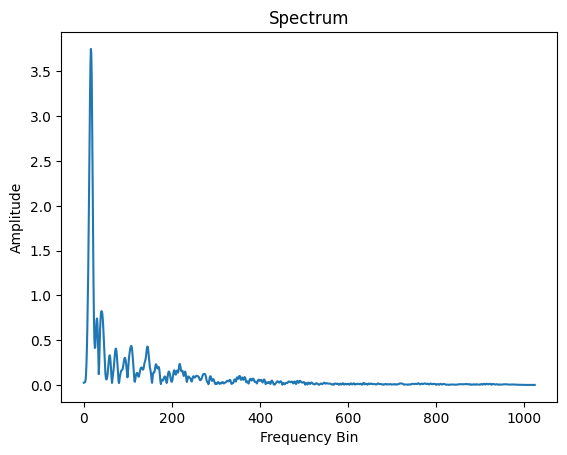

In [25]:
waveplot = librosa.display.waveshow(audio, sr=sample_rate)
plt.show()

n_fft = 2048
ft = np.abs(librosa.stft(audio[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');
plt.show()

Now, let's see a full spectrogram of a whole loaded music. It's scaled in dB.
Note: FFT (and short time FFT, too) gives both positive and negative results. 
The sign here is unrelevant for us, we care only about the absolute value.

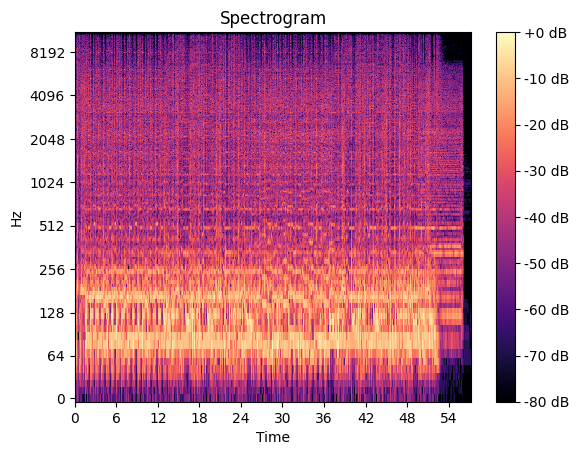

In [15]:
spec = np.abs(librosa.stft(audio, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sample_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');
plt.show()

Now...
as humans do not perceive frequencies on a linear scale (we're detecting lower freqs much better than higher freqs), 
we will use what is called a mel scale (proposed by Stevens, Volkmann, and Newmann back in 1937).

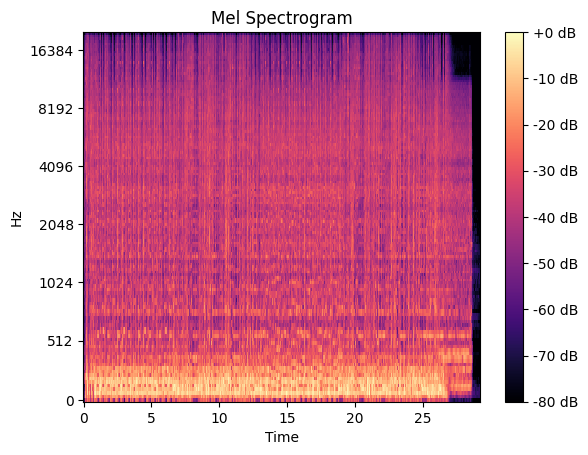

In [16]:
mel_spect = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');
plt.show()

Let's start working on our texture. 
We want it to be made of two parts: one for showing up the waveform of a short time window,
and the another for showing up a mel spectrogram of the same window.

In [17]:
frame_rate = 30.0 # framerate of a video
current_time = 14.0 # in seconds
current_frame = int(current_time * frame_rate)
number_of_frames = 1
sample_start = int((current_frame) / frame_rate * sample_rate)
sample_end = int((current_frame + number_of_frames) / frame_rate * sample_rate)
audio_part = audio[sample_start:sample_end]

The waveform part is easy and straightforward.

In [18]:
def array_to_red_image(array):
    img = None
    # grey image from array
    img = Image.fromarray(array, mode='L')
    # empty grey image
    zero = np.zeros(array.shape, dtype=np.uint8)
    img_zero = Image.fromarray(zero, mode='L')
    # merge it. Real image goes to R channel, while G and B channels filled with zeroes
    img = Image.merge(mode='RGB', bands=(img, img_zero, img_zero))
    return img

Waveform size: 750


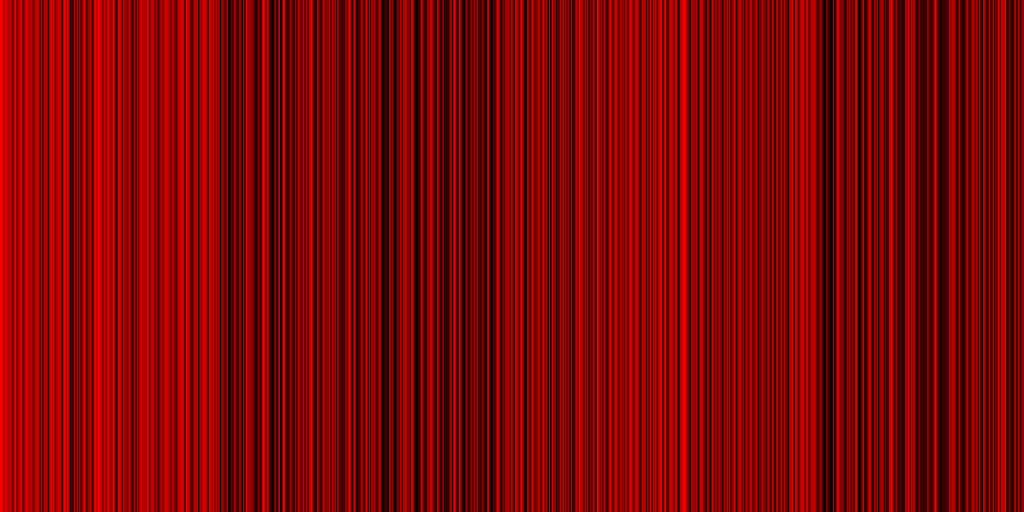

In [19]:
audio_part_img = exposure.rescale_intensity(audio_part, out_range=(-1.0, 1.0))
print(f'Waveform size: {audio_part_img.size}')
# convert to image
audio_wave_img = array_to_red_image(audio_part_img)
# rotate and resize
audio_wave_img = audio_wave_img.rotate(-90, expand=True)
audio_wave_img = audio_wave_img.resize((1024,512))
#audio_wave_img.save('audiowave_array.png')
display(audio_wave_img)

For a mel spectrogram, we will do some cropping, rotating etc. ;)

number of samples: 750, n_FFT: 750


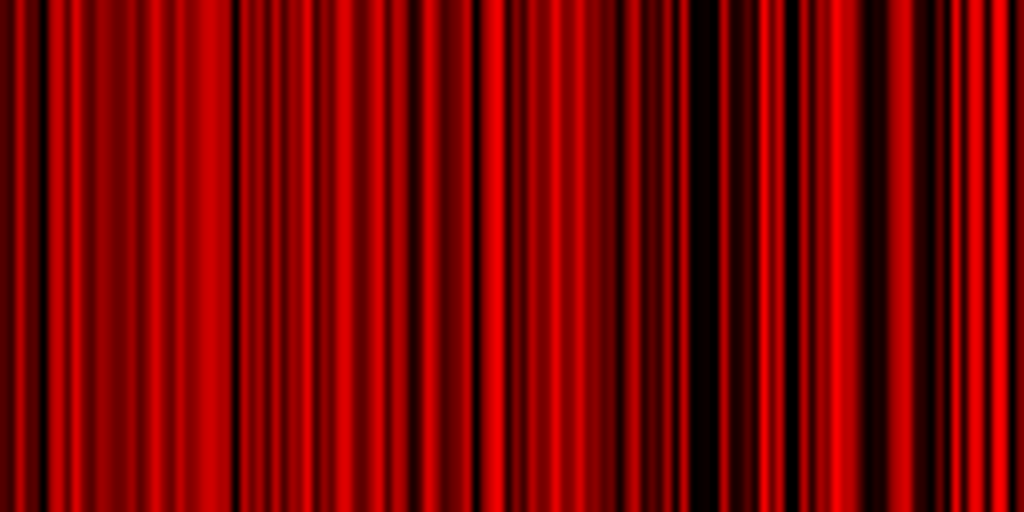

In [20]:
number_of_samples = sample_end-sample_start
n_fft = int(number_of_samples)
print(f'number of samples: {number_of_samples}, n_FFT: {n_fft}')
mel_spect = librosa.feature.melspectrogram(y=audio_part, sr=sample_rate, n_fft=n_fft, hop_length=n_fft)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
melspect_img = array_to_red_image(mel_spect)

# take first column
melspect_img = melspect_img.crop((0, 0, 1, melspect_img.size[1]))
# rotate and resize
melspect_img = melspect_img.rotate(-90, expand=True)
spectrogram_image = melspect_img.resize((1024,512))

display(spectrogram_image)
#spectrogram_image.save('spectrogram_array.png')

So, we have all required parts to construct a final texture.
Note: t was calculated for a current video frame, so it would have to be
recalculated on each frame!

We take both parts and concatenate into one square texture.

Img1 size: 1024:512
Img2 size: 1024:512
Final image size: (1024, 1024)


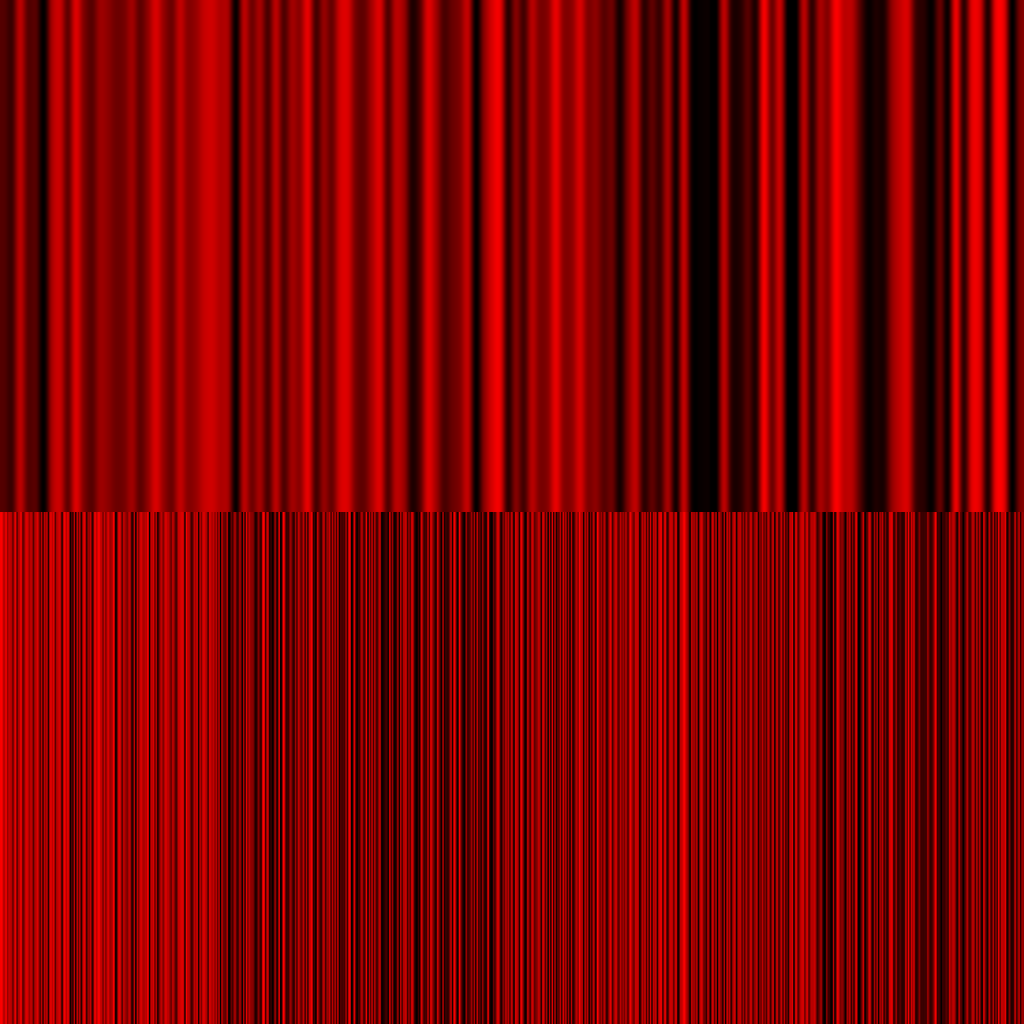

In [21]:
width_spec, height_spec = spectrogram_image.size
width_wave, height_wave = audio_wave_img.size
print(f'Img1 size: {width_spec}:{height_spec}')
print(f'Img2 size: {width_wave}:{height_wave}')

final_img = Image.new('RGB', size=(width_spec,height_spec+height_wave))
final_img.paste(spectrogram_image, (0, 0))
final_img.paste(audio_wave_img, (0, height_spec))
final_img.save('final_texture.png')
print(f'Final image size: {final_img.size}')
display(final_img)